<a href="https://colab.research.google.com/github/unburied/DS-Unit-2-Tree-Ensembles/blob/master/DS_Sprint_Challenge_7_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

In [0]:
!pip install category_encoders

In [0]:
#imports
import numpy as np
import category_encoders as ce
 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import (roc_auc_score, roc_curve, 
                             classification_report,
                             confusion_matrix,
                             accuracy_score)

In [0]:
#2009-10 season through 2016-17 season to train, 
#2017-18 season to validate, 
#2018-19 season to test
import datetime as dt

#Train split
train_season_start_date = dt.datetime(2009,10,1)
train_season_end_date = dt.datetime(2017, 7, 1)
X_train = df[(df.index >= train_season_start_date) & 
             (df.index <= train_season_end_date)]

#validation split
val_season_start_date = dt.datetime(2017,10,1)
val_season_end_date = dt.datetime(2018,7,1)
X_val = df[(df.index >= val_season_start_date) &
           (df.index <= val_season_end_date)]

#test split
test_season_start_date = dt.datetime(2018,10,1)
test_season_end_date = dt.datetime(2019,7,1)
X_test = df[(df.index >= test_season_start_date) &
            (df.index <= test_season_end_date)]                   

In [0]:
#Train had 11081 observations
assert X_train.shape[0] == 11081

#validation set has 1168 observations
assert X_val.shape[0] == 1168

#test set has 1709 observations
assert X_test.shape[0] == 1709

In [20]:
#Get baseline accuracy for the validation set
target = 'shot_made_flag'

#assemble baseline using tartget data
y_train = X_train[target]
majority_class = y_train.mode()
y_test = [majority_class] * len(y_train)

print(f'The baseline accuracy of this data is {accuracy_score(y_train,y_test)}')

The baseline accuracy of this data is 0.5272087356736757


In [0]:
def wrangle(df):
  X = df.copy()
  
  #drop columns that add no real value
  no_val = ['game_id', 'game_event_id', 'player_name']
  X = X.drop(columns= no_val)
  
  #drop outliers
  half_court_distance = 47
  X.shot_distance = np.where(X.shot_distance >= half_court_distance,
                             np.nan, X.shot_distance)
  X.shot_zone_range = np.where(X.shot_zone_range == 'Back Court Shot',
                               np.nan, X.shot_zone_range)
  X = X.dropna()
  
  return X

In [0]:
#Wrangle data
X_train = wrangle(X_train)
X_val = wrangle(X_val)
X_test = wrangle(X_test)

In [0]:
#Chosen features for encoding
cat_features = ['action_type', 'shot_type', 'shot_zone_area',
                'shot_zone_basic', 'shot_zone_range', 'season_type']

#pass features on initialization
encoder = ce.OrdinalEncoder(cols = cat_features)

#encode data
X_train_encoded =  encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

#drop unused cols
unused = ['htm','vtm']
X_train_encoded = X_train_encoded.drop(columns = unused)
X_val_encoded = X_val_encoded.drop(columns = unused)

In [0]:
#pop target variables
y_train = X_train_encoded.pop('shot_made_flag')
y_val = X_val_encoded.pop('shot_made_flag')

In [0]:
#initialize and fit model
rfc= RandomForestClassifier(n_estimators = 500,
                            max_depth = 15,
                            min_samples_leaf = 2,
                            min_samples_split = 2,
                            bootstrap = True)

model = rfc.fit(X_train_encoded, y_train)

In [61]:
#get accuracy
y_test = model.predict(X_val_encoded)
print(f'The accuracy of this model is {accuracy_score(y_val, y_test)}')

The accuracy of this model is 0.5936151855047455


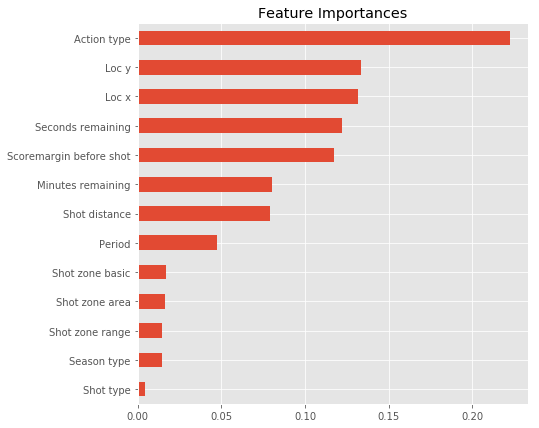

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

#Clean up cloumn names and create a series of feature importances
columns = X_train_encoded.columns.str.replace('_',' ').str.capitalize()
importances = pd.Series(model.feature_importances_, columns)

#Plot that figure
fig = plt.figure(figsize = (7,7))
plt.style.use('ggplot')

ax = importances.sort_values().plot.barh()
ax.set_title('Feature Importances')

plt.show();

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

In [72]:
#Calculate accuracy, precision, and recall for this confusion matrix:
true_negative = 85
false_negative = 8

true_positive = 36
false_positive = 58

total = 85 + 8 + 58 +36
#accuracy is the sum of correct predictions divided by total predictions
accuracy = (true_positive + true_negative) / (total)

#precision is class accuracy of actual results
pos_precision = true_positive / (true_positive + false_positive)
neg_precision = true_negative / (true_negative + false_negative)

#recall is class accuracy of predicted results
pos_recall = true_positive / (true_positive + false_negative)
neg_recall = true_negative / (true_negative + false_positive)

print(f'The accuracy of this model the table represents is {accuracy}')
print(f'The precision of the positive class is {pos_precision}')
print(f'The precision of the negative class is {neg_precision}')
print(f'The recall of the positive class is {pos_recall}')
print(f'The recall of the negative class is {neg_recall}')

The accuracy of this model the table represents is 0.6470588235294118
The precision of the positive class is 0.3829787234042553
The precision of the negative class is 0.9139784946236559
The recall of the positive class is 0.8181818181818182
The recall of the negative class is 0.5944055944055944


In [94]:
#f1 score
f1_pos = 2 / ((1/pos_precision) + (1/pos_recall))
f1_neg = 2 / ((1/neg_precision) + (1/neg_recall))

print(f'The f1 score of the positive class is {f1_pos}')
print(f'The f1 score of the negative class is {f1_neg}')

The f1 score of the positive class is 0.5217391304347826
The f1 score of the negative class is 0.7203389830508475


In [0]:
#feature engineering
def fe(df):
  X = df.copy()
  
  #Homecourt Advantage
  X['hca'] = np.where(X.htm == 'GSW', 1, 0)
  
  #Determine Opponent
  X['opp'] = np.where(X.htm != 'GSW', X.htm,
                          np.where(X.vtm != 'GSW', X.vtm, np.nan))
  
  #Seconds remaining in period
  X['srp'] = (X.minutes_remaining * 60) + X.seconds_remaining
  
  #Seconds remaining in game
  X['srg'] = (X.period * 12 * 60) + X.seconds_remaining
  
  return X

In [0]:
#add new features to split data
X_train = fe(X_train)
X_val = fe(X_val)
X_test = fe(X_test)

In [86]:
#Recycle previous code to rerun model
#Chosen features for encoding
cat_features = ['action_type', 'shot_type', 'shot_zone_area',
                'shot_zone_basic', 'shot_zone_range', 'season_type', 
                'hca', 'opp']

#pass features on initialization
encoder = ce.OrdinalEncoder(cols = cat_features)

#encode data
X_train_encoded =  encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

#drop unused cols
unused = ['htm','vtm']
X_train_encoded = X_train_encoded.drop(columns = unused)
X_val_encoded = X_val_encoded.drop(columns = unused)

#pop target variables
y_train = X_train_encoded.pop('shot_made_flag')
y_val = X_val_encoded.pop('shot_made_flag')

#initialize and fit model
rfc= RandomForestClassifier(n_estimators = 500,
                            max_depth = 15,
                            min_samples_leaf = 2,
                            min_samples_split = 2,
                            bootstrap = True)

model = rfc.fit(X_train_encoded, y_train)

#get accuracy
y_pred = model.predict(X_val_encoded)
print(f'The accuracy of this model is {accuracy_score(y_val, y_pred)}')

The accuracy of this model is 0.5979292493528904


In [87]:
#using test data now
X_test_encoded = encoder.transform(X_test)
X_test_encoded =X_test_encoded.drop(columns = unused)

y_test = X_test_encoded.pop('shot_made_flag')

y_pred = model.predict(X_test_encoded)
print(f'The accuracy using the test data is {accuracy_score(y_test, y_pred)}')

The accuracy using the test data is 0.6312056737588653


In [0]:
#Confusion matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    
    cm = confusion_matrix(y_true, y_pred)
    cm = cm/cm.sum(axis=1).reshape(len(labels), 1)
   
    table = pd.DataFrame(cm, columns=columns, index=index)
    
    return sns.heatmap(table, annot=True, fmt='.2f', cmap='viridis')

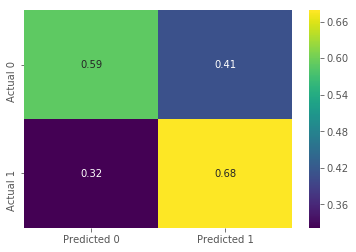

In [93]:
plot_confusion_matrix(y_test, y_pred);

In [91]:
#classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.59      0.63       896
           1       0.59      0.68      0.63       796

    accuracy                           0.63      1692
   macro avg       0.63      0.63      0.63      1692
weighted avg       0.64      0.63      0.63      1692

